In [14]:
import numpy as np
import pandas as pd 
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu

import sys
sys.path.append('/volper/users/alayaelm/Documents/git/wasslsp')

from src.utils import *
from src.kernels import Kernel

init_notebook_mode(connected=True) ## plotly init

import os
path_data = '/volper/users/alayaelm/Documents/git/wasslsp/data/'



In [15]:
df_hr = pd.read_csv(path_data + 'HRVProcessedData[[Beat]].csv')

In [16]:
df_hr.head(), df_hr.columns, df_hr.shape

(   Unnamed: 0   Time        niHR        RR
 0           1  0.000  182.926773  328.0001
 1           2  0.328  182.926773  328.0001
 2           3  0.716  154.639375  387.9995
 3           4  1.124  147.058679  408.0004
 4           5  1.500  159.574468  376.0000,
 Index(['Unnamed: 0', 'Time', 'niHR', 'RR'], dtype='object'),
 (17178, 4))

In [17]:
df_hr['niHR_scaled'] = df_hr[['niHR']]

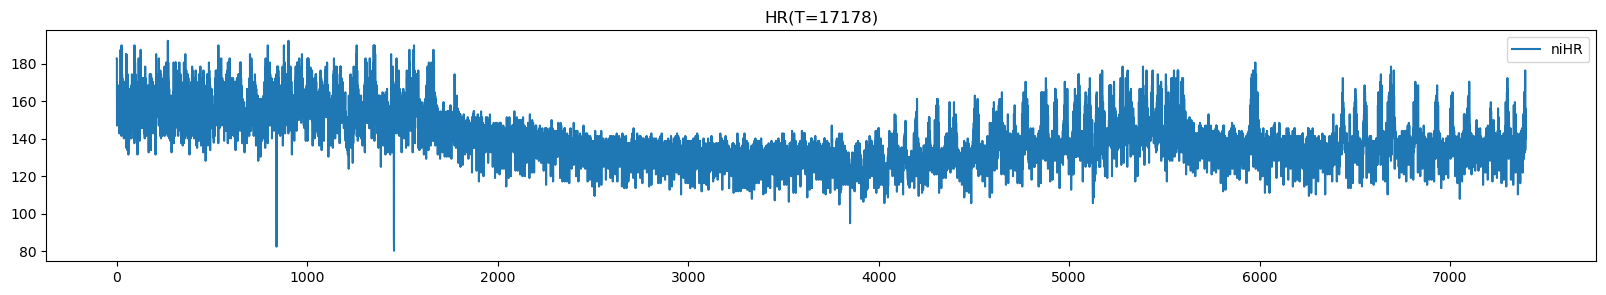

In [18]:
plt.rcParams["figure.figsize"] = (20,3)
#plt.plot(df_hr['Time'], df_hr['niHR'], label="niHR")
plt.plot(df_hr['Time'], df_hr['niHR_scaled'], label="niHR")
plt.legend()
plt.title("HR(T=17178)")
plt.show()

## Nadarawatson estimator 

In [13]:
# C = 2
space_kernel = "gaussian" # "silverman"
time_kernel = "uniform"
T = df_hr.shape[0]
d = 1
bandwidth = T **(-0.4 / (d+1)) / 30 #0.1 # 0.05
X_dict = df_hr['niHR'].values.reshape(-1,1) #df_malleco['Value'].diff().values.reshape(-1, 1)
X_tvar_2 = df_hr['niHR'].values #df_malleco['Value'].diff().values

GaussUnifKernel = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)
GaussUnifKernel 
Y_t_T = df_hr['niHR'].values

weights = {}
for t in range(T):
    weights[str(t)] = GaussUnifKernel.fit(X_dict, t)
    
m_hat= [np.sum(weights[str(t)] * Y_t_T) for t in range(T)]

KeyboardInterrupt: 

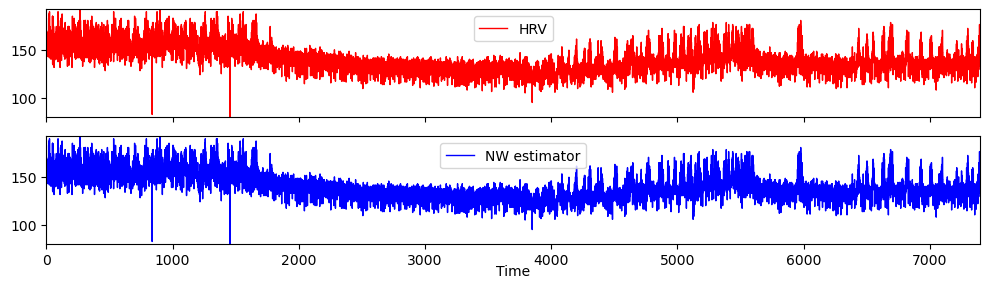

2024/06/04 22:25:15 Saved result in file HRV-NW-Gaussian-sp-Uniform-time-C-15.pdf


In [27]:
import logging

logging.basicConfig(
    format="%(asctime)s %(message)s", datefmt="%Y/%m/%d %H:%M:%S", level=logging.INFO
)

path_fig = "/Users/mzalaya/Library/CloudStorage/Dropbox/research/git/wasslsp/figs/"

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,3) , sharex=True)
plt.subplots_adjust(wspace=0, hspace=0.02)
# plt.rcParams['axes.grid'] = True
# plt.rcParams['axes.facecolor'] = 'black'

output_filename = "HRV-NW-Gaussian-sp-Uniform-time-C-15.pdf"
# from matplotlib.colors import ListedColormap
# cm = plt.cm.RdBu
# cm_bright = ListedColormap(["#FF0000", "#0000FF"])

ax[0].plot(df_hr['Time'].values, X_tvar_2, lw=1, label="HRV", color="#FF0000")  # #, color="r") #, cmap=cm)
ax[0].set_xlim(min(df_hr['Time'].values), max(df_hr['Time'].values))
ax[0].set_ylim(min(min(m_hat), min(X_tvar_2)),  max(max(m_hat), max(X_tvar_2)))
ax[0].legend(loc='upper center')

ax[1].plot(df_hr['Time'].values, np.array(m_hat), lw=1, label="NW estimator" , c="#0000FF")#cm_bright[0]) #"orange")
ax[1].set_xlim(min(df_hr['Time'].values), max(df_hr['Time'].values))
ax[1].set_ylim(min(min(m_hat), min(X_tvar_2)),  max(max(m_hat), max(X_tvar_2)))
ax[1].legend(loc='upper center')
ax[1].set_xlabel("Time")
ax[1].xaxis.set_label_coords(0.5, -0.19)
plt.savefig(path_fig+output_filename, dpi=300)
plt.tight_layout()
plt.show()
logging.info("Saved result in file %s" % output_filename)

In [25]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

np.sqrt(mse(np.array(m_hat), X_tvar_2)), mae(np.array(m_hat), X_tvar_2)

(1.4874896022207777e-05, 5.408111373910678e-07)

In [ ]:
# C = 0.1 (0.19753487518485374, 0.1521864406875735)
# C = 10 (1.5284993345152873e-05, 5.885175159826092e-07) 
# C = 15 (1.5133207374047727e-05, 5.724991791154624e-07
# C = 30 (1.4874896022207777e-05, 5.408111373910678e-07)

# NW Conditional CDF

In [19]:
def replication_HRV(data=None, sigma=1., d=1, n_replications=1):
    """
    Replication genearating procedure of HRV data
    """
    T = data.shape[0]
    
    X_tvar_2 = np.zeros(T)
    X_tvar_2_replications = np.zeros((n_replications, T))

    X_dict = {}
    for replication in range(n_replications):
        t = 1
        epsilon = np.random.normal(size=(T), scale=sigma)
        X = np.zeros((T,d))
        while t <= T-1 :
            X_tvar_2[t] = df_hr['niHR_scaled'].values[t] + epsilon[t]
            X[t] = [X_tvar_2[t-1]]
            t += 1
        
        X_dict[str(replication)] = X
        X_tvar_2_replications[replication] = X_tvar_2
        
    return X_tvar_2_replications

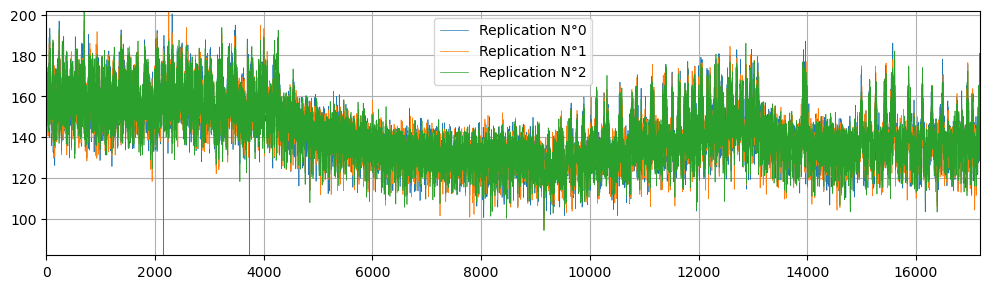

In [51]:
plt.rcParams["figure.figsize"] = (10,3)

u_var = np.linspace(0., 1., T)
# sigmas = np.array([1, 0.1, 0.01, 0.001, 0.0001])
sigma = 4.
n_replications = 3

X_tvar_2_replications = replication_HRV(
    data=df_hr['niHR'], sigma=sigma, n_replications=n_replications
)

for replication in range(n_replications):
    plt.plot(X_tvar_2_replications[replication], lw=.5, label='Replication N°' f'{replication}')
    plt.ylim(min(X_tvar_2_replications[replication][1:,]), max(X_tvar_2_replications[replication]))
    plt.xlim(0, T)
    
    plt.grid(True)
    plt.legend()
    
plt.tight_layout()
plt.savefig("3 replications of HRV dataset")
plt.show()

In [52]:
# times_t = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]
times_t = [7750, 8000, 8250, 8500, 8750, 9000, 9250, 9500]
times_T = [T]
n_replications = 3
d = 1

In [53]:
T = df_hr['niHR'].shape[0]

In [54]:
xi = 0.4 / (2*(d+1))
lambda_ = 1/12
T = df_hr['niHR'].shape[0]
bandwidth = lambda_ * ( T **(-xi) )
uvals = np.array(times_t) / T
uvals

array([0.45115846, 0.46571196, 0.48026546, 0.49481895, 0.50937245,
       0.52392595, 0.53847945, 0.55303295])

In [23]:
mask = []
for val in uvals:
    bool_ = (val >= bandwidth) and (val <= 1-bandwidth)
    mask.append(bool_)

In [24]:
mask

[np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_]

In [57]:
[(val >= bandwidth) and (val <= 1-bandwidth) for val in uvals ]

[np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_]

In [49]:
uvals.all() in np.array([bandwidth, 1-bandwidth])

AssertionError: 

In [10]:
xi = 0.499/ 2*(d+1)
times_T * np.array(times_T)**(-xi) /20

array([6.61745926])

In [55]:
X_tvar_2 = {}
X_tvar_2_replications = {}
X_dict = {}

# "T:"+str(T
for T in times_T:
    X_tvar_2_replications[f"T:{T}"] = np.zeros((n_replications, T))
    X_dict[f"T:{T}"] = {}

In [56]:
import torch
import scipy as scp
import matplotlib
from matplotlib import cm
from scipy.stats import wasserstein_distance

In [57]:
X_tvar_2_replications

{'T:17178': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])}

In [58]:
for T in times_T:
    u_var = np.linspace(0., 1., T)

    for replication in range(n_replications):
        # sigma_star = lambda u: sigma
        t = 1
        epsilon = np.random.normal(size=T, scale=sigma)
        X = np.zeros((T,d))
        X_tvar_2_T = np.zeros(T)
        while t <= T-1 :
            X_tvar_2_T[t] = df_hr['niHR'].values[t] + epsilon[t]
            X[t] = [X_tvar_2_T[t-1]]
            t += 1

        X_tvar_2_replications[f"T:{T}"][replication] = X_tvar_2_T
        X_dict[f"T:{T}"][str(replication)] = X


In [59]:
X_tvar_2 = {}

for t in times_t:
    for T in times_T:
        X_tvar_2[f"t:{t}_T:{T}"] = {}

# X_tvar_2

In [60]:
for t in times_t:
    for T in times_T:
        X_tvar_2[f"t:{t}_T:{T}"] = []


for t in times_t:
    for replication in range(n_replications):
        for T in times_T:
            z = X_tvar_2_replications[f"T:{T}"][replication][t-1]
            X_tvar_2[f"t:{t}_T:{T}"].append(z)

for t in times_t:
    for T in times_T:
        X_tvar_2[f"t:{t}_T:{T}"] = np.array(X_tvar_2[f"t:{t}_T:{T}"])

In [61]:
plt.rcParams["figure.figsize"] = (5,4)

norm_X_tvar_2 = {}
for t in times_t:
    for T in times_T:
        norm_X_tvar_2[f"t:{t}_T:{T}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_T:{T}"])
        #sns.lineplot(
            #x=X_tvar_2[f"t:{t}_T:{T}"], y=norm_X_tvar_2[f"t:{t}_T:{str(T)}"], lw=2, markers=True,
            #label=f"(t,T)={t, T}",  drawstyle='steps-mid',          
        #)
        #plt.legend()
        #plt.tight_layout()

# space_kernel = "gaussian"; time_kernel = "uniform"

In [62]:
space_kernel = "gaussian" #"silverman"
time_kernel = "uniform" #"tricube"
xi = 0.4 / (2*(d+1))
lambda_ = 1/12
bandwidth = lambda_ * ( T **(-xi) )

gaussian_kernel = {}
gaussian_weights = {}

for t in times_t:
    for T in times_T:
        gaussian_weights[f"t:{t}_T:{T}"] = {}
    
for T in times_T:
    bandwidth = lambda_ * ( T **(-xi) )
    gaussian_kernel[f"T:{T}"] = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)

In [63]:
gaussian_kernel

{'T:17178': Kernel(T=17178, bandwidth=0.03142834371256549, time_kernel='uniform')}

In [64]:
n_replications = 3
for replication in range(n_replications):
    for t in times_t:
        for T in times_T:
            # print(X_dict[f"T:{T}"][str(replication)].shape, "\n")
            # print(gaussian_kernel[f"T:{T}"], "\n")
            # print(gaussian_weights[f"t:{t}_T:{T}"], "\n")
            gaussian_weights[f"t:{t}_T:{T}"][str(replication)] = \
            gaussian_kernel[f"T:{T}"].fit(X_dict[f"T:{T}"][str(replication)], t)

In [65]:
times_t, 4*10**(-6)

([7750, 8000, 8250, 8500, 8750, 9000, 9250, 9500], 4e-06)

In [66]:
gaussian_weights_tensor =  {} #= torch.empty((len(times_t), len(times_T), )

# torch.zeros((len(times_t), len(times_T), n_replications, None))
# gaussian_weights_tensor.size() # torch.Size([len(times_t), len(times_T), n_replications])

for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):
        gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"] = {}

times_T = [T]
for i_t in range(len(times_t)):
    for i_T in range(len(times_T)): 
        for replication in range(n_replications):
            gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)] =\
            gaussian_weights[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)]

In [67]:
empirical_cds = {}
for t in times_t:
    for T in times_T:
        empirical_cds[f"t:{t}_T:{T}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_T:{T}"])


In [68]:
def eval_univariate(x, weights):
        """Inner function for ECDF of one variable."""
        sorter = x.argsort()
        x = x[sorter]
        weights = weights[sorter]
        y = weights.cumsum()

        # if self.stat in ["percent", "proportion"]:
        y = y / y.max()
        # if self.stat == "percent":
            # y = y * 100

        # x = np.r_[-np.inf, x]
        # y = np.r_[0, y]
        x = np.r_[x]
        y = np.r_[y]

        # if self.complementary:
            # y = y.max() - y

        return y, x

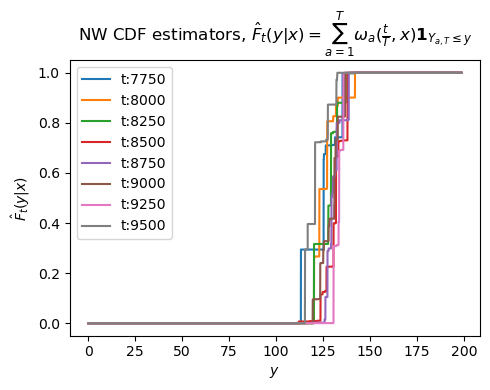

In [69]:


x_rep = {} 
y_rep = {} 

wasserstein_distances = {}

for t in times_t:
    for T in times_T:
        x_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        y_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        wasserstein_distances[f"t:{t}_T:{T}"] = {}

for replication in range(1): #range(n_replications): #range(n_replications):
   # sns.lineplot(x=X_tvar_2_replications[replication], y=replicated_NW_cdfs_100[str(replication)])
   # plt.ecdf(X_tvar_2_replications[replication], weights=weights_100[str(replication)][99])
   # sns.ecdfplot(data=None, x=X_tvar_2_replications[replication], weights=weights_100[str(replication)][99])
   # data = X_tvar_2_replications[replication] * weights_100[str(replication)][99]
   # plt.plot(np.sort(a), np.linspace(0., 1., len(a), endpoint=False), c='g',lw=2)
   # plt.plot(np.sort(data), np.arange(1, len(data)+1) / len(data))
    for t in times_t:
        for T in times_T:
            y, x = eval_univariate(
                X_tvar_2_replications[f"T:{T}"][replication], gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)]
                # gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)] * X_tvar_2_replications[f"T:{T}"][replication]
            )
            x_rep[f"t:{t}_T:{str(T)}"][replication] = x
            y_rep[f"t:{t}_T:{str(T)}"][replication] = y
            distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvar_2_replications[f"T:{T}"][replication]))
            wasserstein_distances[f"t:{t}_T:{T}"][str(replication)] = distance
   
   
            plt.plot(x, y, label=f"t:{t}")# _replication:{replication}")
            plt.xlabel(r'$y$')
            plt.ylabel(r'$\hat{F}_t(y|x)$')
            # plt.xticks(np.arange(0, T+1, 200, dtype=int))
            #plt.xlim(-18, 18)
            plt.title(r'NW CDF estimators, $\hat{F}_{t}(y|{x})=\sum_{a=1}^T\omega_{a}(\frac{t}{T},{x})\mathbf{1}_{Y_{a,T}\leq y}$')
            plt.legend()
            plt.tight_layout()
            #plt.savefig(path_fig+"nadar_watson_weights_", dpi=150)

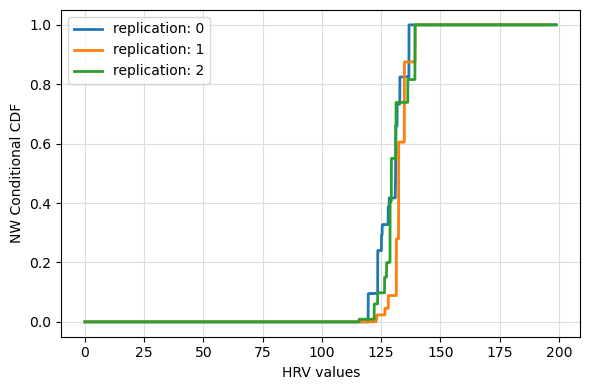

In [70]:


x_rep = {} 
y_rep = {} 
t_values_new = [9000]
wasserstein_distances = {}

for t in t_values_new:
    for T in times_T:
        x_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        y_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        wasserstein_distances[f"t:{t}_T:{T}"] = {}

for replication in range(n_replications): 
    for t in t_values_new:
        for T in times_T:
            y, x = eval_univariate(
                X_tvar_2_replications[f"T:{T}"][replication], gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)]
            )
            x_rep[f"t:{t}_T:{str(T)}"][replication] = x
            y_rep[f"t:{t}_T:{str(T)}"][replication] = y
            distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvar_2_replications[f"T:{T}"][replication]))
            wasserstein_distances[f"t:{t}_T:{T}"][str(replication)] = distance
   
   
            plt.rcParams["figure.figsize"] = (6,4)
            plt.plot(x, y, label=f"replication: {replication}", lw=2)# _replication:{replication}")
            plt.xlabel("HRV values")
            plt.ylabel("NW Conditional CDF")
            plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
            plt.legend()
plt.tight_layout()
plt.savefig("3 NW estimators of L=3 replications HRV.png")

In [71]:
x_rep = {} 
y_rep = {} 

wasserstein_distances = {}

for t in times_t:
    for T in times_T:
        x_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        y_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        wasserstein_distances[f"t:{t}_T:{T}"] = {}

for replication in range(n_replications):
    for t in times_t:
        for T in times_T:
            y, x = eval_univariate(
                X_tvar_2_replications[f"T:{T}"][replication], gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)]
                # gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)] * X_tvar_2_replications[f"T:{T}"][replication]
            )
            x_rep[f"t:{t}_T:{str(T)}"][replication] = x
            y_rep[f"t:{t}_T:{str(T)}"][replication] = y
            distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvar_2_replications[f"T:{T}"][replication]))
            wasserstein_distances[f"t:{t}_T:{T}"][str(replication)] = distance
   
   
            # plt.plot(x, y, label=f"t:{t}_T:{T}")# _replication:{replication}")
            # plt.xlabel(r'$y$')
            # plt.ylabel(r'$\hat{F}_t(y|x)$')
            # plt.xlim(-18, 18)
            # plt.title(r'NW CDF estimators, $\hat{F}_{t}(y|{x})=\sum_{a=1}^T\omega_{a}(\frac{t}{T},{x})\mathbf{1}_{Y_{a,T}\leq y}$')
            # plt.legend()
            # plt.tight_layout()
            # plt.savefig(path_fig+"nadar_watson_weights_", dpi=150)

In [45]:
wass_distances_all_replications = {}

for t in times_t:
    for T in times_T:
        wass_distances_all_replications[f"t:{t}_T:{T}"] = []

for t in times_t:
    for T in times_T:       
        for replications in range(n_replications):
            wass_distances_all_replications[f"t:{t}_T:{T}"].append(wasserstein_distances[f"t:{t}_T:{T}"][str(replication)])
        

In [46]:
plt.rcParams["figure.figsize"] = (10,3)
wass_distances_empirical_meanNW = {}
for t in times_t:
    for T in times_T:
        wass_distances_empirical_meanNW[f"t:{t}_T:{T}"] = wasserstein_distance(
            empirical_cds[f"t:{t}_T:{T}"], y_rep[f"t:{t}_T:{T}"].mean(axis=0)
        )

In [47]:
wass_distances_empirical_meanNW

{'t:7750_T:17178': np.float64(0.1754339459971143),
 't:8000_T:17178': np.float64(0.07588456050312703),
 't:8250_T:17178': np.float64(0.14721902722332414),
 't:8500_T:17178': np.float64(0.23010265465753818),
 't:8750_T:17178': np.float64(0.21674572716824247),
 't:9000_T:17178': np.float64(0.2063565592594704),
 't:9250_T:17178': np.float64(0.25604497979741336),
 't:9500_T:17178': np.float64(0.1280745987431337)}

# space_kernel = "silverma"; time_kernel = "tricube"

In [105]:
space_kernel = "silverman"
time_kernel = "tricube"
xi = 0.4 / (2*(d+1))

gaussian_kernel = {}
gaussian_weights = {}

for t in times_t:
    for T in times_T:
        gaussian_weights[f"t:{t}_T:{T}"] = {}
    
for T in times_T:
    bandwidth = T **(-xi) / 10
    gaussian_kernel[f"T:{T}"] = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)

In [106]:
gaussian_kernel

{'T:17178': Kernel(T=17178, bandwidth=0.03771401245507859, space_kernel='silverman',
        time_kernel='tricube')}

In [107]:
for replication in range(n_replications):
    for t in times_t:
        for T in times_T:
            # print(X_dict[f"T:{T}"][str(replication)].shape, "\n")
            # print(gaussian_kernel[f"T:{T}"], "\n")
            # print(gaussian_weights[f"t:{t}_T:{T}"], "\n")
            gaussian_weights[f"t:{t}_T:{T}"][str(replication)] = \
            gaussian_kernel[f"T:{T}"].fit(X_dict[f"T:{T}"][str(replication)], t-1)

In [108]:
n_replications

20

In [109]:
gaussian_weights_tensor =  {} #= torch.empty((len(times_t), len(times_T), )

# torch.zeros((len(times_t), len(times_T), n_replications, None))
# gaussian_weights_tensor.size() # torch.Size([len(times_t), len(times_T), n_replications])

for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):
        gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"] = {}


for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):  
        for replication in range(n_replications):
            gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)] =\
            gaussian_weights[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)]

In [110]:
empirical_cds = {}
for t in times_t:
    for T in times_T:
        empirical_cds[f"t:{t}_T:{T}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_T:{T}"])


In [111]:
def eval_univariate(x, weights):
        """Inner function for ECDF of one variable."""
        sorter = x.argsort()
        x = x[sorter]
        weights = weights[sorter]
        y = weights.cumsum()

        # if self.stat in ["percent", "proportion"]:
        y = y / y.max()
        # if self.stat == "percent":
            # y = y * 100

        # x = np.r_[-np.inf, x]
        # y = np.r_[0, y]
        x = np.r_[x]
        y = np.r_[y]

        # if self.complementary:
            # y = y.max() - y

        return y, x

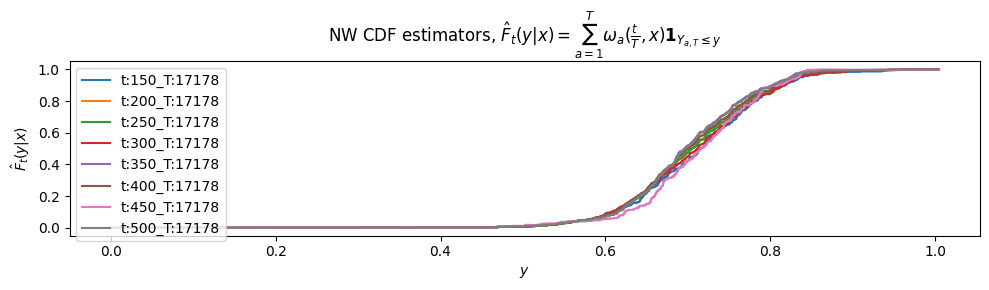

In [113]:


x_rep = {} 
y_rep = {} 

wasserstein_distances = {}

for t in times_t:
    for T in times_T:
        x_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        y_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        wasserstein_distances[f"t:{t}_T:{T}"] = {}

for replication in range(1): #range(n_replications): #range(n_replications):
   # sns.lineplot(x=X_tvar_2_replications[replication], y=replicated_NW_cdfs_100[str(replication)])
   # plt.ecdf(X_tvar_2_replications[replication], weights=weights_100[str(replication)][99])
   # sns.ecdfplot(data=None, x=X_tvar_2_replications[replication], weights=weights_100[str(replication)][99])
   # data = X_tvar_2_replications[replication] * weights_100[str(replication)][99]
   # plt.plot(np.sort(a), np.linspace(0., 1., len(a), endpoint=False), c='g',lw=2)
   # plt.plot(np.sort(data), np.arange(1, len(data)+1) / len(data))
    for t in times_t:
        for T in times_T:
            y, x = eval_univariate(
                X_tvar_2_replications[f"T:{T}"][replication], gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)]
                # gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)] * X_tvar_2_replications[f"T:{T}"][replication]
            )
            x_rep[f"t:{t}_T:{str(T)}"][replication] = x
            y_rep[f"t:{t}_T:{str(T)}"][replication] = y
            distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvar_2_replications[f"T:{T}"][replication]))
            wasserstein_distances[f"t:{t}_T:{T}"][str(replication)] = distance
   
   
            plt.plot(x, y, label=f"t:{t}_T:{T}")# _replication:{replication}")
            plt.xlabel(r'$y$')
            plt.ylabel(r'$\hat{F}_t(y|x)$')
            # plt.xticks(np.arange(0, T+1, 200, dtype=int))
            #plt.xlim(-18, 18)
            plt.title(r'NW CDF estimators, $\hat{F}_{t}(y|{x})=\sum_{a=1}^T\omega_{a}(\frac{t}{T},{x})\mathbf{1}_{Y_{a,T}\leq y}$')
            plt.legend()
            plt.tight_layout()
            #plt.savefig(path_fig+"nadar_watson_weights_", dpi=150)

In [114]:
x_rep = {} 
y_rep = {} 

wasserstein_distances = {}

for t in times_t:
    for T in times_T:
        x_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        y_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        wasserstein_distances[f"t:{t}_T:{T}"] = {}

for replication in range(n_replications):
    for t in times_t:
        for T in times_T:
            y, x = eval_univariate(
                X_tvar_2_replications[f"T:{T}"][replication], gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)]
                # gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)] * X_tvar_2_replications[f"T:{T}"][replication]
            )
            x_rep[f"t:{t}_T:{str(T)}"][replication] = x
            y_rep[f"t:{t}_T:{str(T)}"][replication] = y
            distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvar_2_replications[f"T:{T}"][replication]))
            wasserstein_distances[f"t:{t}_T:{T}"][str(replication)] = distance
   
   
            # plt.plot(x, y, label=f"t:{t}_T:{T}")# _replication:{replication}")
            # plt.xlabel(r'$y$')
            # plt.ylabel(r'$\hat{F}_t(y|x)$')
            # plt.xlim(-18, 18)
            # plt.title(r'NW CDF estimators, $\hat{F}_{t}(y|{x})=\sum_{a=1}^T\omega_{a}(\frac{t}{T},{x})\mathbf{1}_{Y_{a,T}\leq y}$')
            # plt.legend()
            # plt.tight_layout()
            # plt.savefig(path_fig+"nadar_watson_weights_", dpi=150)

In [115]:
wass_distances_all_replications = {}

for t in times_t:
    for T in times_T:
        wass_distances_all_replications[f"t:{t}_T:{T}"] = []

for t in times_t:
    for T in times_T:       
        for replications in range(n_replications):
            wass_distances_all_replications[f"t:{t}_T:{T}"].append(wasserstein_distances[f"t:{t}_T:{T}"][str(replication)])
        

In [116]:
plt.rcParams["figure.figsize"] = (10,3)
wass_distances_empirical_meanNW = {}
for t in times_t:
    for T in times_T:
        wass_distances_empirical_meanNW[f"t:{t}_T:{T}"] = wasserstein_distance(
            empirical_cds[f"t:{t}_T:{T}"], y_rep[f"t:{t}_T:{T}"].mean(axis=0)
        )

In [117]:
wass_distances_empirical_meanNW

{'t:150_T:17178': 0.6412501805340607,
 't:200_T:17178': 0.6130997638676484,
 't:250_T:17178': 0.6473614507038346,
 't:300_T:17178': 0.665922389840888,
 't:350_T:17178': 0.5876130722425764,
 't:400_T:17178': 0.6104352104633626,
 't:450_T:17178': 0.6289556913068788,
 't:500_T:17178': 0.6270218876554692}